In [1]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.12.0
Eager execution: True


In [2]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /home/ruoyancai/.keras/datasets/iris_training.csv


In [3]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [4]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(
    train_dataset_fp,
    batch_size, 
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.


In [5]:
features, labels = next(iter(train_dataset))

features


OrderedDict([('sepal_length',
              <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
              array([6.1, 4.4, 4.9, 5.7, 5.9, 5.1, 4.6, 6. , 6.1, 4.8, 5.1, 5. , 5.1,
                     6.4, 4.9, 6.3, 4.8, 5.5, 6.1, 6.9, 6.6, 4.4, 5.2, 5. , 5.8, 4.9,
                     6.8, 6.7, 6.8, 6.4, 7.7, 5.8], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
              array([2.8, 2.9, 3.1, 2.9, 3.2, 3.5, 3.6, 3. , 2.9, 3.1, 2.5, 3.3, 3.8,
                     2.8, 3.1, 3.3, 3.4, 2.4, 2.8, 3.1, 2.9, 3. , 3.4, 2. , 4. , 2.4,
                     3. , 3.1, 2.8, 2.8, 2.8, 2.7], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([4.7, 1.4, 1.5, 4.2, 4.8, 1.4, 1. , 4.8, 4.7, 1.6, 3. , 1.4, 1.6,
                     5.6, 1.5, 6. , 1.6, 3.8, 4. , 5.1, 4.6, 1.3, 1.4, 3.5, 1.2, 3.3,
                     5.5, 4.4, 4.8, 5.6, 6.7, 4.1],

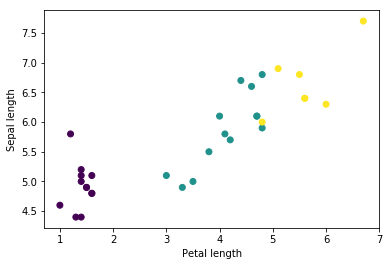

In [6]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length");

In [7]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels
train_dataset = train_dataset.map(pack_features_vector)
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.8 3.  5.5 2.1]
 [6.3 2.3 4.4 1.3]
 [7.6 3.  6.6 2.1]
 [5.  3.5 1.3 0.3]
 [4.8 3.1 1.6 0.2]], shape=(5, 4), dtype=float32)


In [15]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [17]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.3862965106964111


In [18]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.3862965106964111
Step: 1,         Loss: 1.328563928604126


In [20]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 1.390, Accuracy: 30.000%
Epoch 050: Loss: 1.044, Accuracy: 35.000%
Epoch 100: Loss: 0.761, Accuracy: 70.000%
Epoch 150: Loss: 0.568, Accuracy: 76.667%
Epoch 200: Loss: 0.476, Accuracy: 85.833%


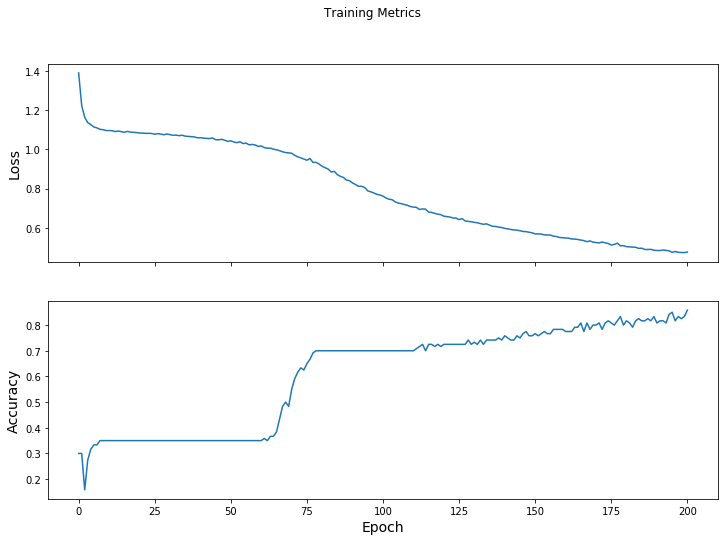

In [21]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results);